In [1]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point

In [39]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()


In [55]:
basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_9");
basinsall = basins
image = ee.Image('WWF/HydroSHEDS/03VFDEM');

a = pd.read_csv('a.csv')

In [41]:
def numberOfPixels(img):
    imgDescription = ee.Algorithms.Describe( img )
    height = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(0);
    width = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(1);
  
    print("width", width.getInfo() )
    print("height", height.getInfo() )
  
    return  ee.Number( width ).multiply( ee.Number( height ) ).getInfo()


In [42]:
geom = pd.read_csv('a.csv')
geom = geom.sort_values('Latitude (decimal degrees)')
latlon = [[i,j] for [i,j] in zip(geom['Longitude (decimal degrees)'].values,
                              geom['Latitude (decimal degrees)'].values)][:-1]
c=0
for i in latlon[1:400]:
    if (np.isnan(i[0]))|(np.isnan(i[1])):
        latlon.pop(c)
    c+=1

In [43]:
pts = ee.Geometry.MultiPoint(latlon)

In [52]:
#basins = basins.filterBounds(pts)

In [275]:
#basins = ee.FeatureCollection(basins)
#basins = basins.merge(basins2)
import matplotlib.pyplot as plt

In [276]:
a1  = basins.getInfo()

In [277]:
b=a1

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
for i in range(len(b['features'])):
    try:
        ax.plot(np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,0],np.array(b['features'][i]['geometry']['coordinates']).squeeze()[:,1])
    except:
        print('here')

In [84]:
def queryeach(b):
    feat = ee.Feature(b)
    print(feat.getInfo())

In [32]:
myImage = image.clip(ee.FeatureCollection(basins.first().geometry()))

AttributeError: 'Point' object has no attribute 'to_geojson'

In [270]:
None


In [33]:
drainageDirectionVis = {
  'min': 0.0,
  'max': 2000,
  }

In [294]:
#def meanDictionary(geom):
    #def featurescount(feature):
        #return feature
#a = image.reduceRegions(basins,ee.Reducer.mean());
image2 = ee.Terrain.slope(image)
b = image2.reduceRegions(basins,ee.Reducer.percentile([20, 50, 80, 95]))
b2 = image2.reduceRegions(basins,ee.Reducer.mean())
    #return a.filter(ee.Filter.notNull(['mean'])).map(featurescount)
#b = basins.map(meanDictionary)

In [295]:
print(b2)

ee.FeatureCollection({
  "functionInvocationValue": {
    "functionName": "Image.reduceRegions",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.loadTable",
          "arguments": {
            "tableId": {
              "constantValue": "WWF/HydroSHEDS/v1/Basins/hybas_9"
            }
          }
        }
      },
      "image": {
        "functionInvocationValue": {
          "functionName": "Terrain.slope",
          "arguments": {
            "input": {
              "functionInvocationValue": {
                "functionName": "Image.load",
                "arguments": {
                  "id": {
                    "constantValue": "WWF/HydroSHEDS/03VFDEM"
                  }
                }
              }
            }
          }
        }
      },
      "reducer": {
        "functionInvocationValue": {
          "functionName": "Reducer.mean",
          "arguments": {}
        }
      }
    }
  }
})


In [296]:
def rm_geom(feature):
    feature = feature.setGeometry(None)
    return feature

b2=b2.map(rm_geom)

In [300]:
mytask.active()

True

In [297]:
mytask = ee.batch.Export.table.toDrive(collection=b2, folder='data_earth_engine', description='basins_slope_means', fileFormat='CSV')

mytask.start()

In [301]:
mytask.active()

True

In [ ]:
def meanDictionary(geom):
    return image.clip(geom.geometry())
mns = basins.map(meanDictionary)

In [ ]:
basins.getInfo()

In [283]:
import matplotlib.pyplot as plt

In [284]:
a = np.array(a)

## Begin basin analysis

In [65]:
basins_slopes = pd.read_csv('/Users/gr_1/Downloads/basins_slope_percentiles.csv')

In [475]:
basin_slopes_mean = pd.read_csv('/Users/gr_1/Downloads/basins_slope_means.csv')

In [476]:
basins_2 = pd.read_pickle('BASINS_ALL')


In [477]:
#basins_2['HYBAS_ID'] = basins_2.index
basins_2.index = range(len(basins_2))
basins_2['p95'] = basins_slopes['p95']
basins_2['p80'] = basins_slopes['p80']
basins_2['p50'] = basins_slopes['p50']
basins_2['p20'] = basins_slopes['p20']
basins_2['mean_slope'] = basin_slopes_mean['mean']



In [478]:
if 0: # we did it once so we can load it now
    up_basins = []
    ids = basins_2['HYBAS_ID'].values
    down_ids = basins_2['NEXT_DOWN'].values
    c=0
    def recurbas(l,c):
        c+=1
        idx = ids[down_ids==l]
        for j in idx:
            if j != l:
                if c>10000:
                    print(j,l)
                idx = np.append(idx,recurbas(j,c))

        return idx
    for i in range(len(ids)):
        up_basins.append(recurbas(ids[i],c))
        c=0
        if np.mod(i,1000) == 0:
            print(i/len(ids))

In [479]:
# basins_2 = gpd.GeoDataFrame(basins_2)
# ptgeo = []
# for i, geo in enumerate(basins_2['.geo']):
#     geo2 = ast.literal_eval(geo)
#     try:
#         ptgeo.append(Polygon(geo2['coordinates'][0]))
#     except:
#         ptgeo.append(MultiPolygon(geo2['coordinates'][0],geo2['coordinates'][1]))

In [480]:
#basins_2.geometry = ptgeo

In [481]:
# basins = gpd.GeoDataFrame()
# c=0
# for pt in pt_gpd.geometry:
#     basins = basins.append(basins_2[basins_2.contains(pt)])
#     print(len(basins))
#     print(c)
#     c+=1

In [2]:
pt_basins = pd.read_pickle('pt_basins')
a = pd.read_csv('a.csv')


In [3]:
pts = []
for x,y in zip(a["Longitude (decimal degrees)"],a['Latitude (decimal degrees)']):
    pts.append(Point(x,y))

In [4]:
pt_gpd = gpd.GeoDataFrame(a)
a['geometry'] = pts

In [5]:
ptgeo = []
for i, geo in enumerate(pt_basins['.geo']):
    geo2 = ast.literal_eval(geo)
    try:
        ptgeo.append(Polygon(geo2['coordinates'][0]))
    except:
        ptgeo.append(MultiPolygon(geo2['coordinates'][0],geo2['coordinates'][1]))


In [6]:
basins_gpd = gpd.GeoDataFrame(pt_basins,geometry = ptgeo)

In [18]:
basins_save = gpd.GeoDataFrame(geometry=ptgeo)

In [19]:
len(ptgeo)

1329

In [21]:
basins_save = basins_save.drop_duplicates()

In [22]:
len(basins_save)

516

In [23]:
basins_save.to_file('basins_pt')

In [508]:
basins_gpd.index = basins_gpd['HYBAS_ID']
basins_2['SUB_AREA'][basins_2['p95'].isna()] = .00000000001
basins_2['p95'][basins_2['p95'].isna()] = 0
#basins_2['SUB_AREA'][basins_2['p50'].isna()] = .00000000001
basins_2['p95'][basins_2['p50'].isna()] = 0
basins_gpd['p95'] = basins_2['p95']
basins_gpd['p50'] = basins_2['p50']
basins_gpd['mean_slope'] = basins_2['mean_slope']
basins_2.index = basins_2['HYBAS_ID']
#basins_gpd['HYBAS_ID'] = basins_gpd.index
basins_gpd.index = range(len(basins_gpd))

<ipython-input-508-66546328be75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basins_2['SUB_AREA'][basins_2['p95'].isna()] = .00000000001
<ipython-input-508-66546328be75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basins_2['p95'][basins_2['p95'].isna()] = 0
<ipython-input-508-66546328be75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basins_2['p95'][basins_2['p50'].isna()] = 0


In [ ]:
c=1
d=1
for i,pt in pt_gpd.iterrows():
    basin = basins_gpd[basins_gpd.contains(pt.geometry)]
    if len(basin) >0:
        basin = basin.iloc[0:1]
        pt_gpd.loc[i,'Basin_id'] = basin['HYBAS_ID'].values
        upstream_basins = basins_2["NEXT_UP"][basin['HYBAS_ID']].values[0]
        #if len(upstream_basins) > 0:
        basum = basins_2['mean'][upstream_basins].values
        areas = basins_2['SUB_AREA'][upstream_basins].values
        pt_gpd.loc[i,'mean_topo'] = (basin['mean'].values*basin['SUB_AREA'].values +
                                     np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                          basin['SUB_AREA'].values[0])
        basum = basins_2['p95'][upstream_basins].values

        pt_gpd.loc[i,'95_slope_mean'] = (basin['p95'].values*basin['SUB_AREA'].values +
                                     np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                          basin['SUB_AREA'].values[0])
        basum = basins_2['p50'][upstream_basins].values
        pt_gpd.loc[i,'50_slope_mean'] = (basin['p50'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0]) +
                                                                                                     basin['SUB_AREA'].values[0])
        basum = basins_2['mean_slope'][upstream_basins].values
        pt_gpd.loc[i,'mean_slope_all'] = (basin['mean_slope'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0]) + basin['SUB_AREA'].values[0])
        if np.isnan(pt_gpd.loc[i,'50_slope_mean']):
            print('broken')
      #  print(np.sum(areas[basum>0]) +basin['SUB_AREA'].values[0])
    else:
        c+=1

In [566]:
import sklearn.metrics as mt

In [532]:
pt_gpd['Mean Basin Slope (°)'] = pd.to_numeric(pt_gpd['Mean Basin Slope (°)'], errors='coerce')

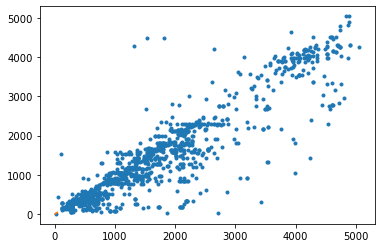

In [595]:
plt.plot(pt_gpd['Mean Basin Elevation (m)'],pt_gpd['mean_topo'],'.')
plt.plot(np.arange(0,40),np.arange(0,40))

(array([1175, 1389]),)

In [597]:
x = np.log(pt_gpd['Mean Basin Elevation (m)'])
y = np.log(pt_gpd['mean_topo'])
I = np.where(np.logical_or(np.isnan(x.values),np.isnan(y.values)))[0]
x = x.drop(I)
y = y.drop(I)
mt.r2_score(x, y)

0.5236938274961602

In [601]:
from sklearn.linear_model import LinearRegression

In [606]:
l.fit()

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

0.1867435375847193

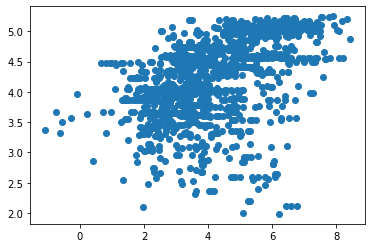

In [626]:
x = np.log(pt_gpd['mean_slope_all'])
y = np.log(pt_gpd['CRONUS Erosion Rate (m My)'])
I = np.where(np.logical_or(np.isnan(x.values),np.isnan(y.values)))[0]
x = x.drop(I).to_numpy()
y = y.drop(I).to_numpy()
l = LinearRegression().fit(x.reshape(-1,1),y.reshape(-1,1))
y_ = l.predict(x.reshape(-1,1))
plt.scatter(y,y_)

mt.r2_score(y, y_)

In [549]:
pt_gpd

,Unnamed: 0,Citation,Sample ID,Location,Latitude (decimal degrees),Longitude (decimal degrees),Mean Basin Elevation (m),Basin Relief (m),Basin Area (km ),Mean Latitude (decimal degrees),...,,type,dist,dist_bin,geometry,Basin_id,mean_topo,95_slope_mean,50_slope_mean,mean_slope_all
0,26,Belmont et al. (2007),Lower_EFMC,"Clearwater River, Washington, United States",47.654,-124.240,239.0,376,13.61,47.686,...,NaN,basinwide,133.065703,22,POINT (-124.24000 47.65400),7.090343e+09,341.127463,31.869465,inf,16.191463
1,525,Heimsath et al. (2001),OR-16,"Coast Range, Oregon, United States",43.469,-124.113,296.0,345,3.59,43.472,...,NaN,basinwide,131.505098,22,POINT (-124.11300 43.46900),7.090014e+09,95.408404,25.628412,inf,11.198064
2,460,NaN,ORK,"Redwood Creek at Orick, Coast Range, Californi...",41.289,-124.060,575.0,1619,720.45,41.060,...,NaN,basinwide,130.750392,22,POINT (-124.06000 41.28900),7.090014e+09,573.951708,26.369799,inf,16.075120
3,27,NaN,Upper_WC,NaN,47.739,-124.044,636.0,501,1.73,47.743,...,NaN,basinwide,132.913228,22,POINT (-124.04400 47.73900),7.090343e+09,341.127463,31.869465,inf,16.191463
4,28,NaN,Lower_WC,NaN,47.729,-124.037,563.0,606,4.22,47.746,...,NaN,basinwide,132.903103,22,POINT (-124.03700 47.72900),7.090343e+09,341.127463,31.869465,inf,16.191463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,530,NaN,NR-38,NaN,-36.667,150.000,1018.0,239,4.66,-36.636,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1386,531,NaN,NR-58,NaN,-36.667,150.000,919.0,864,23.17,-36.629,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1387,532,NaN,NR-60,NaN,-36.667,150.000,919.0,864,23.17,-36.629,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1388,528,Heimsath et al. (2006),NR-32,"Nunnock River Basin, Southeast Australia",-36.667,150.000,1005.0,251,5.98,-36.636,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998


[None, None]

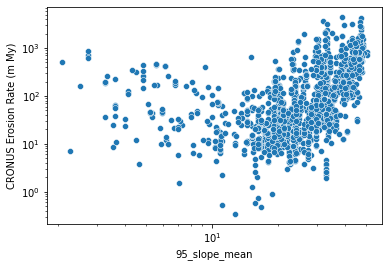

In [562]:
ax = sns.scatterplot(data=pt_gpd,x='95_slope_mean',y='CRONUS Erosion Rate (m My)')

ax.set(xscale="log", yscale="log")

[None, None]

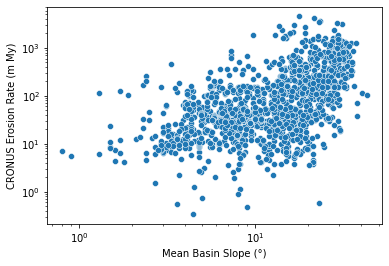

In [557]:
ax = sns.scatterplot(data=pt_gpd,x='Mean Basin Slope (°)',y='CRONUS Erosion Rate (m My)')
ax.set(xscale="log", yscale="log")